In [1]:
# Include project path to available custom class at jupyter
import os
import sys
sys.path.insert(0, os.path.abspath('/stacked_ensemble/'))

# Disable warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Import libraries Python/Keras
import importlib
import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import pandas as pd
import utils.definition_network as dn
import pickle

## Plot frequence terms
from textblob import TextBlob
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
# import plotly.plotly as py

import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
from plotly.subplots import make_subplots
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
# from bokeh.plotting import figure, output_file, show
# from bokeh.models import Label
# from bokeh.io import output_notebook
# output_notebook()

## LDA
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm

### 1.0 Auxiliary Functions

In [3]:
def load_word_embeddings(): 
    dep_word_emb_df = pd.read_pickle(
        dn.PATH_PROJECT + "experiments/data_mining/ensemble_tests/domain_vocabulary/dep_word_emb.df")
    
    anx_word_emb_df = pd.read_pickle(
        dn.PATH_PROJECT + "experiments/data_mining/ensemble_tests/domain_vocabulary/anx_word_emb.df")
    
    return anx_word_emb_df, dep_word_emb_df

In [4]:
def generate_plot_total_posts(df, type_plot='general'):
    if type_plot == 'general':
        g = sns.catplot(x="label", y="total_posts", hue="correct_prediction", kind="bar", 
                        height=6.27, aspect=9.7/8.27,
                        data=df.sort_values(by=['label']))
        g.set(xlabel= 'User Class', ylabel='Total Posts', title='Distribution of Posts by User Class')
        g.set_xticklabels(rotation=0)
        g._legend.set_title('Correct Prediction')
    elif type_plot == 'overlay':
        x0 = df.loc[df['label'] == 'control', 'total_posts']
        x1 = df.loc[df['label'] == 'anxiety', 'total_posts']
        x2 = df.loc[df['label'] == 'depression', 'total_posts']
        x3 = df.loc[df['label'] == 'anxiety,depression', 'total_posts']

        trace0 = go.Histogram(
            x=x0, 
            name='Control',
            marker_color='#0A8D0E',
            opacity=0.75            
        )

        trace1 = go.Histogram(
            x=x1, 
            name = 'Anxiety',
            marker_color='#FA1507',
            opacity=0.75
        )

        trace2 = go.Histogram(
            x=x2, 
            name = 'Depression',
            marker_color='#FAF307',
            opacity=0.75
        )

        trace3 = go.Histogram(
            x=x3, 
            name = 'Comorbidity',
            marker_color='#E0711F',
            opacity=0.75
        )

        data = [trace0, trace1, trace2, trace3]
        layout = go.Layout(barmode='overlay', xaxis_title='Total Posts', yaxis_title='Total Users', 
                           title='Distribution of Posts by User Class ('+\
                                 'Correct Predict = '+str(df[0:1].correct_prediction.values[0])+')')
        fig = go.Figure(data=data, layout=layout)

        iplot(fig, filename='overlaid histogram')
    else:
        max_total_posts = df['total_posts'].max()
        xbins = dict(start = 0, end = max_total_posts, size = int(max_total_posts/10))

        max_total_users = df['total_posts'].count()
        ybins = dict(start = 0, end = max_total_posts, size = int(max_total_users/10))
        
        correct_pred = '(Correct Predict = '+str(df[0:1].correct_prediction.values[0])+')'

        x0 = df.loc[df['label'] == 'control', 'total_posts']
        x1 = df.loc[df['label'] == 'anxiety', 'total_posts']
        x2 = df.loc[df['label'] == 'depression', 'total_posts']
        x3 = df.loc[df['label'] == 'anxiety,depression', 'total_posts']

        fig = make_subplots(rows=2, cols=2, x_title='Total Posts', y_title='Total Users '+correct_pred,
                            subplot_titles=('Distribution of Total Posts by Control User',
                                            'Distribution of Total Posts by Anxiety User',
                                            'Distribution of Total Posts by Depression User',
                                            'Distribution of Total Posts by Comorbidity User'))

        trace0 = go.Histogram(x=x0, name='Control', marker_color='#0A8D0E',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace1 = go.Histogram(x=x1, name='Anxiety', marker_color='#FA1507',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace2 = go.Histogram(x=x2, name='Depression', marker_color='#F7DC30',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace3 = go.Histogram(x=x3, name='Comorbidity', marker_color='#E0711F',
                              autobinx = False, xbins = xbins, ybins = ybins)

        fig.append_trace(trace0, 1, 1)
        fig.append_trace(trace1, 1, 2)
        fig.append_trace(trace2, 2, 1)
        fig.append_trace(trace3, 2, 2)

        fig.show()        

In [5]:
def generate_plot_total_terms(df, type_plot='general'):
    if type_plot == 'general':
        g = sns.catplot(x="label", y="total_terms", hue="correct_prediction", kind="box", 
                        height=6.27, aspect=9.7/8.27, 
                data=sub_smhd_test.sort_values(by=['label']))
        g.set(xlabel= 'User Class', ylabel='Total Terms/User',
        title='Distribution of Total Terms by User Class')
        g._legend.set_title('Correct Prediction')
    elif type_plot == 'overlay':
        x0 = df.loc[df['label'] == 'control', 'total_terms']
        x1 = df.loc[df['label'] == 'anxiety', 'total_terms']
        x2 = df.loc[df['label'] == 'depression', 'total_terms']
        x3 = df.loc[df['label'] == 'anxiety,depression', 'total_terms']

        trace0 = go.Histogram(
            x=x0, 
            name='Control',
            marker_color='#0A8D0E',
            opacity=0.75            
        )

        trace1 = go.Histogram(
            x=x1, 
            name = 'Anxiety',
            marker_color='#FA1507',
            opacity=0.75
        )

        trace2 = go.Histogram(
            x=x2, 
            name = 'Depression',
            marker_color='#FAF307',
            opacity=0.75
        )

        trace3 = go.Histogram(
            x=x3, 
            name = 'Comorbidity',
            marker_color='#E0711F',
            opacity=0.75
        )

        data = [trace0, trace1, trace2, trace3]
        layout = go.Layout(barmode='overlay', xaxis_title='Total Terms '+correct_pred, yaxis_title='Users', 
                           title='Distribution of Total Terms by User Class ('+\
                                 'Correct Predict = '+str(df[0:1].correct_prediction)+')')
        fig = go.Figure(data=data, layout=layout)

        iplot(fig, filename='overlaid histogram')
    else:
        max_total_posts = df['total_terms'].max()
        xbins = dict(start = 0, end = max_total_posts, size = int(max_total_posts/10))

        max_total_users = df['total_terms'].count()
        ybins = dict(start = 0, end = max_total_posts, size = int(max_total_users/10))
        
        correct_pred = '(Correct Predict = '+str(df[0:1].correct_prediction.values[0])+')'
        
        x0 = df.loc[df['label'] == 'control', 'total_terms']
        x1 = df.loc[df['label'] == 'anxiety', 'total_terms']
        x2 = df.loc[df['label'] == 'depression', 'total_terms']
        x3 = df.loc[df['label'] == 'anxiety,depression', 'total_terms']

        fig = make_subplots(rows=2, cols=2, x_title='Total Terms', y_title='Total Users '+correct_pred,
                            subplot_titles=('Distribution of Total Terms by Control User',
                                            'Distribution of Total Terms by Anxiety User',
                                            'Distribution of Total Terms by Depression User',
                                            'Distribution of Total Terms by Comorbidity User'))

        trace0 = go.Histogram(x=x0, name='Control', marker_color='#0A8D0E',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace1 = go.Histogram(x=x1, name='Anxiety', marker_color='#FA1507',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace2 = go.Histogram(x=x2, name='Depression', marker_color='#F7DC30',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace3 = go.Histogram(x=x3, name='Comorbidity', marker_color='#E0711F',
                              autobinx = False, xbins = xbins, ybins = ybins)

        fig.append_trace(trace0, 1, 1)
        fig.append_trace(trace1, 1, 2)
        fig.append_trace(trace2, 2, 1)
        fig.append_trace(trace3, 2, 2)

        fig.show()                

In [6]:
def generate_plot_median_posts(df, type_plot='general'):
    if type_plot == 'general':
        g = sns.catplot(x="label", y="median_terms", hue="correct_prediction", kind="box", 
                        height=6.27, aspect=9.7/8.27, 
                data=sub_smhd_test.sort_values(by=['label']))
        g.set(xlabel= 'User Class', ylabel='Median Terms/Posts',
        title='Median Distribution of Terms/Posts by User Class')
        g._legend.set_title('Correct Prediction')
    elif type_plot == 'overlay':
        x0 = df.loc[df['label'] == 'control', 'median_terms']
        x1 = df.loc[df['label'] == 'anxiety', 'median_terms']
        x2 = df.loc[df['label'] == 'depression', 'median_terms']
        x3 = df.loc[df['label'] == 'anxiety,depression', 'median_terms']

        trace0 = go.Histogram(
            x=x0, 
            name='Control',
            marker_color='#0A8D0E',
            opacity=0.75            
        )

        trace1 = go.Histogram(
            x=x1, 
            name = 'Anxiety',
            marker_color='#FA1507',
            opacity=0.75
        )

        trace2 = go.Histogram(
            x=x2, 
            name = 'Depression',
            marker_color='#FAF307',
            opacity=0.75
        )

        trace3 = go.Histogram(
            x=x3, 
            name = 'Comorbidity',
            marker_color='#E0711F',
            opacity=0.75
        )

        data = [trace0, trace1, trace2, trace3]
        layout = go.Layout(barmode='overlay', xaxis_title='Median Total Terms '+correct_pred, yaxis_title='Users', 
                           title='Distribution of Total Terms by User Class '+\
                                 'Correct Predict = '+str(df[0:1].correct_prediction)+')')
        fig = go.Figure(data=data, layout=layout)

        iplot(fig, filename='overlaid histogram')
    else:
        max_total_posts = df['median_terms'].max()
        xbins = dict(start = 0, end = max_total_posts, size = int(max_total_posts/10))

        max_total_users = df['median_terms'].count()
        ybins = dict(start = 0, end = max_total_posts, size = int(max_total_users/10))
        
        correct_pred = '(Correct Predict = '+str(df[0:1].correct_prediction.values[0])+')'
        
        x0 = df.loc[df['label'] == 'control', 'median_terms']
        x1 = df.loc[df['label'] == 'anxiety', 'median_terms']
        x2 = df.loc[df['label'] == 'depression', 'median_terms']
        x3 = df.loc[df['label'] == 'anxiety,depression', 'median_terms']

        fig = make_subplots(rows=2, cols=2, x_title='Median Total Terms', y_title='Total Users '+correct_pred,
                            subplot_titles=('Distribution of Median Total Terms by Control User',
                                            'Distribution of Median Total Terms by Anxiety User',
                                            'Distribution of Median Total Terms by Depression User',
                                            'Distribution of Median Total Terms by Comorbidity User'))

        trace0 = go.Histogram(x=x0, name='Control', marker_color='#0A8D0E',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace1 = go.Histogram(x=x1, name='Anxiety', marker_color='#FA1507',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace2 = go.Histogram(x=x2, name='Depression', marker_color='#F7DC30',
                              autobinx = False, xbins = xbins, ybins = ybins)
        trace3 = go.Histogram(x=x3, name='Comorbidity', marker_color='#E0711F',
                              autobinx = False, xbins = xbins, ybins = ybins)

        fig.append_trace(trace0, 1, 1)
        fig.append_trace(trace1, 1, 2)
        fig.append_trace(trace2, 2, 1)
        fig.append_trace(trace3, 2, 2)

        fig.show()

### 1.1 Analysis of the dataset generated for each subset - Profile Survey

In [7]:
a_test_df = pd.read_csv(dn.PATH_PROJECT + "dataset/anxiety/SMHD_test_1040_anxiety.csv", sep=';') 
d_test_df = pd.read_csv(dn.PATH_PROJECT + "dataset/depression/SMHD_test_2160_depression.csv", sep=';') 
ad_test_df = pd.read_csv(dn.PATH_PROJECT + "dataset/anxiety,depression/SMHD_test_880_anxiety,depression.csv", sep=';')

a_test_df.insert(a_test_df.columns.__len__(), 'texts', None)
d_test_df.insert(d_test_df.columns.__len__(), 'texts', None)
ad_test_df.insert(ad_test_df.columns.__len__(), 'texts', None)

In [8]:
smhd_1040_test_df= pd.read_pickle(dn.PATH_PROJECT + "dataset/anxiety/SMHD_test_1040.df")
smhd_2160_test_df = pd.read_pickle(dn.PATH_PROJECT + "dataset/depression/SMHD_test_2160.df") 
smhd_880_test_df = pd.read_pickle(dn.PATH_PROJECT + "dataset/anxiety,depression/SMHD_test_880.df")

a_test_df.loc[:, 'texts_vec'] = smhd_1040_test_df.loc[:, 'texts']
d_test_df.loc[:, 'texts_vec'] = smhd_2160_test_df.loc[:, 'texts']
ad_test_df.loc[:, 'texts_vec'] = smhd_880_test_df.loc[:, 'texts']

a_test_df.loc[:, 'texts'] = smhd_1040_test_df.texts.apply(lambda x: " ".join(eval(x)))
d_test_df.loc[:, 'texts'] = smhd_2160_test_df.texts.apply(lambda x: " ".join(eval(x)))
ad_test_df.loc[:, 'texts'] = smhd_880_test_df.texts.apply(lambda x: " ".join(eval(x)))

smhd_test = pd.concat([a_test_df, d_test_df, ad_test_df])
smhd_test = smhd_test.drop_duplicates()

del smhd_1040_test_df, smhd_2160_test_df, smhd_880_test_df, a_test_df, d_test_df, ad_test_df

In [9]:
smhd_test.insert(smhd_test.columns.__len__(), 'total_terms', None)
smhd_test.insert(smhd_test.columns.__len__(), 'mean_terms', None)
smhd_test.insert(smhd_test.columns.__len__(), 'median_terms', None)
smhd_test.insert(smhd_test.columns.__len__(), 'min_terms', None)
smhd_test.insert(smhd_test.columns.__len__(), 'max_terms', None)

smhd_test.loc[:, 'total_terms'] = smhd_test.total_terms_by_post.apply(lambda x: np.array(eval(x)).sum())
smhd_test.loc[:, 'mean_terms'] = smhd_test.total_terms_by_post.apply(lambda x: np.array(eval(x)).mean())
smhd_test.loc[:, 'median_terms'] = smhd_test.total_terms_by_post.apply(lambda x: np.median(np.array(eval(x))))
smhd_test.loc[:, 'min_terms'] = smhd_test.total_terms_by_post.apply(lambda x: np.array(eval(x)).min())
smhd_test.loc[:, 'max_terms'] = smhd_test.total_terms_by_post.apply(lambda x: np.array(eval(x)).max())

smhd_test.head(2)

,user_id,label,total_posts,total_terms_by_post,texts,texts_vec,total_terms,mean_terms,median_terms,min_terms,max_terms
0,8397877,control,126,"[37, 35, 21, 3, 10, 13, 37, 24, 17, 69, 24, 31...","For people who like Sandersons books, it's gre...","[""For people who like Sandersons books, it's g...",3675,29.166667,20.0,1,242
1,3398188,control,178,"[5, 2, 6, 2, 5, 1, 11, 14, 3, 2, 2, 8, 3, 1, 6...",Upvoting because cats are amazing Echo The ab...,"['Upvoting because cats are amazing', 'Echo ',...",1638,9.202247,7.0,1,69


In [10]:
sub_smhd_test_acertos = smhd_test[smhd_test.user_id.isin([8914939,3503437,9921812,9774077,9736388,5786947,6010316,5988984,5786947,2721513,
                                                          1999381,1328668,1082102,4481499,7234837,8070069,6052164,8731721,2396483,3089187,
                                                          3570788,3296308,6530745,1344020,3780413,9021619,5261187,2162431,6443586,1351264,
                                                          7295878,4949124,6900932,6332508,2689455,1560098,3325623,6201558,8156239,8243240])]
sub_smhd_test_acertos.insert(sub_smhd_test_acertos.columns.__len__(), 'correct_prediction', True)

In [11]:
sub_smhd_test_erros = smhd_test[smhd_test.user_id.isin([9500168,9235204,5618223,3947850,1655858,1517477,8471033,3841251,
                                                        6077008,7079292,8457978,4419383,7345135,4337975,6375618,4407771,
                                                        1725087,1989926,5225881,5946486,6283994,9305994,1612691,4741572,
                                                        4528875,6064924,7629799,8824357,9886375,6086555,6811031])]
sub_smhd_test_erros.insert(sub_smhd_test_erros.columns.__len__(), 'correct_prediction', False)

In [12]:
sub_smhd_test = pd.concat([sub_smhd_test_acertos, sub_smhd_test_erros])

del sub_smhd_test_acertos, sub_smhd_test_erros

sub_smhd_test.head(2)

,user_id,label,total_posts,total_terms_by_post,texts,texts_vec,total_terms,mean_terms,median_terms,min_terms,max_terms,correct_prediction
64,8914939,control,110,"[7, 1, 16, 20, 8, 109, 15, 29, 30, 11, 123, 77...",Thumb is most likely a branch /r/MonsantosFin...,"['Thumb is most likely a branch ', '/r/Monsant...",3653,33.209091,14.5,1,239,True
119,3503437,control,505,"[63, 11, 165, 10, 16, 18, 17, 21, 1, 6, 33, 14...",So i was playing my beloved P.T and found out ...,['So i was playing my beloved P.T and found ou...,9287,18.390099,13.0,1,277,True


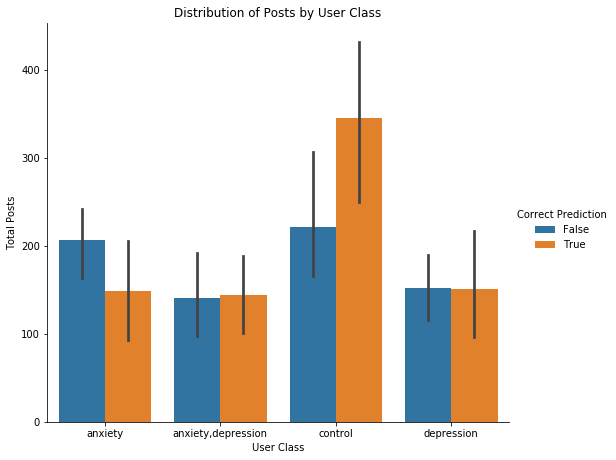

In [13]:
generate_plot_total_posts(sub_smhd_test, type_plot='general')

In [14]:
generate_plot_total_posts(sub_smhd_test[sub_smhd_test.correct_prediction == True], type_plot='overlay')
generate_plot_total_posts(sub_smhd_test[sub_smhd_test.correct_prediction == False], type_plot='overlay')

In [15]:
generate_plot_total_posts(sub_smhd_test[sub_smhd_test.correct_prediction == True], type_plot='specific')
generate_plot_total_posts(sub_smhd_test[sub_smhd_test.correct_prediction == False], type_plot='specific')

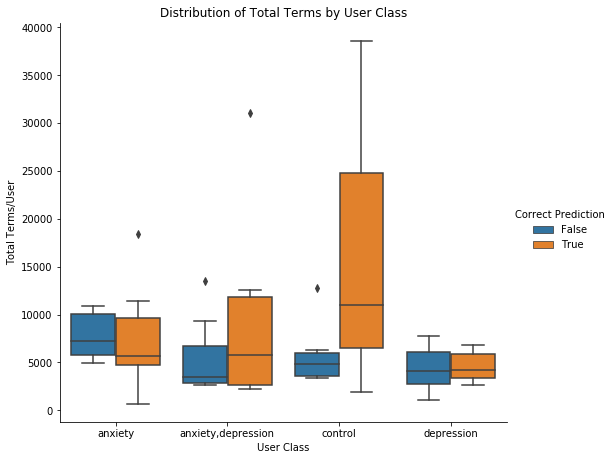

In [16]:
generate_plot_total_terms(sub_smhd_test, type_plot='general')

In [17]:
generate_plot_total_terms(sub_smhd_test[sub_smhd_test.correct_prediction == True], type_plot='specific')
generate_plot_total_terms(sub_smhd_test[sub_smhd_test.correct_prediction == False], type_plot='specific')

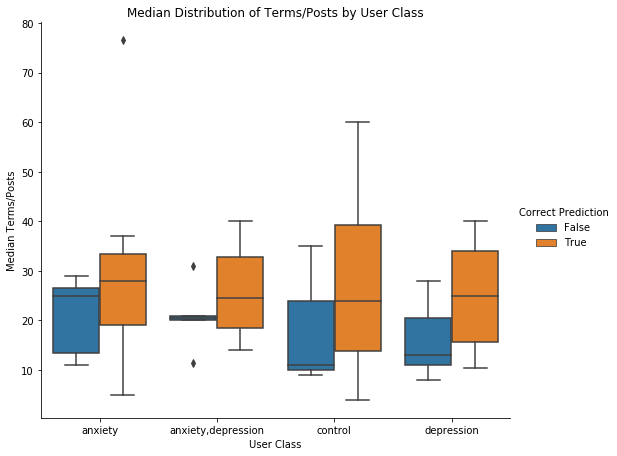

In [18]:
generate_plot_median_posts(sub_smhd_test, type_plot='general')

In [19]:
generate_plot_median_posts(sub_smhd_test[sub_smhd_test.correct_prediction == True], type_plot='specific')
generate_plot_median_posts(sub_smhd_test[sub_smhd_test.correct_prediction == False], type_plot='specific')

### 1.3 Retrieves information saved using SHAP for each sample

#### Auxiliary functions to process more frequent terms

In [4]:
def get_top_n_words(corpus, total_terms=None, remove_stopwords=False, n_grams=None):
    if remove_stopwords:
        if n_grams != None:
            vec = CountVectorizer(ngram_range=n_grams, stop_words = 'english').fit(corpus)
        else:
            vec = CountVectorizer(stop_words = 'english').fit(corpus)
    else:
        if n_grams != None:
            vec = CountVectorizer(ngram_range=n_grams).fit(corpus)
        else:
            vec = CountVectorizer().fit(corpus)
            
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:total_terms]

In [5]:
def find_terms_disorder_dict(domain_dict_df, terms_list, submodel):
    # Defines word embedding of dictionary search according to submodel
    word_emb_submodels = dict({'CA1': 'glove6b',
                               'CA2': 'glove6b',
                               'CA3': 'glove_adad',
                               'CA4': 'glove6b',
                               'CA5': 'glove6b',
                               'CD1': 'glove6b',
                               'CD2': 'glove6b',
                               'CD3': 'w2v_cbow_adad',
                               'CD4': 'glove6b',
                               'CD5': 'glove6b',
                               'CAD1': 'glove6b',
                               'CAD2': 'glove6b',
                               'CAD3': 'w2v_cbow_all_user',
                               'CAD4': 'w2v_skip_adad',
                               'CAD5': 'glove6b',
                               'CAD6': 'glove6b',
                               'CAD7': 'glove_adad',
                               'CAD8': 'glove6b'
                               })
    terms_dict_list = []
    len_dict = len(domain_dict_df[word_emb_submodels[submodel]])
    
    for term in terms_list:
        for i in range(len_dict):
            terms_dict = [[k,v] for (k,v) in dict(domain_dict_df[word_emb_submodels[submodel]][i]).items() \
                          if k == term]
            if len(terms_dict) > 0:
                terms_dict_list.append(terms_dict[0])
        
    return terms_dict_list

In [6]:
def analyze_terms_samples(sample):
    process_samples_lst = []
   
    # Search the 100 most frequent terms, without removing stopwords and compare
    # with the positive and negative terms of the shap
    label = sample[0:1].label.values[0]
    texts = eval(sample[0:1].texts.values[0])
    user_id = sample[0:1].user_id.values[0]
    correct_prediction = sample[0:1].correct_prediction.values[0]
    common_words = get_top_n_words(texts, 100, remove_stopwords=True, n_grams=None)

    submodels = sample.key_model.unique()
    for submodel in submodels:
        if label == 'anxiety,depression':
            pos_words = list(dict.fromkeys(sample[sample.key_model == submodel].word_for_class.values[0]\
                                           ['anxiety']['pos_words'])) + \
                        list(dict.fromkeys(sample[sample.key_model == submodel].word_for_class.values[0]\
                                           ['depression']['pos_words']))
            neg_words = list(dict.fromkeys(sample[sample.key_model == submodel].word_for_class.values[0]\
                                           ['anxiety']['neg_words'])) + \
                            list(dict.fromkeys(sample[sample.key_model == submodel].word_for_class.values[0]\
                                           ['depression']['neg_words']))
        else:
            pos_words = list(dict.fromkeys(sample[sample.key_model == submodel].word_for_class.values[0]\
                                           [label]['pos_words']))
            neg_words = list(dict.fromkeys(sample[sample.key_model == submodel].word_for_class.values[0]\
                                           [label]['neg_words']))

        pos_words = list(dict.fromkeys(pos_words))
        neg_words = list(dict.fromkeys(neg_words))

        # What's in common between the 100 frequent and positive and negative shap values
        common_fre_pos_words = list(dict(common_words).keys() & pos_words)
        common_fre_neg_words = list(dict(common_words).keys() & neg_words)

        # What's different between the 100 frequent and positive and negative shap values
        diff_fre_pos_words = list(pos_words - dict(common_words).keys())
        diff_fre_neg_words = list(neg_words - dict(common_words).keys())

        # search for positive and negative terms, what is in the dictionary according to pathology
        terms_anx_dict_pos_lst = find_terms_disorder_dict(anx_word_emb_df, pos_words, submodel)
        terms_dep_dict_pos_lst = find_terms_disorder_dict(dep_word_emb_df, pos_words, submodel)

        terms_anx_dict_neg_lst = find_terms_disorder_dict(anx_word_emb_df, neg_words, submodel)
        terms_dep_dict_neg_lst = find_terms_disorder_dict(dep_word_emb_df, neg_words, submodel)

        terms_anx_dict_common_lst = find_terms_disorder_dict(anx_word_emb_df, dict(common_words).keys(), submodel)
        terms_dep_dict_common_lst = find_terms_disorder_dict(dep_word_emb_df, dict(common_words).keys(), submodel)

        terms_anx_dict_common_fre_pos_lst = find_terms_disorder_dict(anx_word_emb_df, common_fre_pos_words, submodel)
        terms_dep_dict_common_fre_pos_lst = find_terms_disorder_dict(dep_word_emb_df, common_fre_pos_words, submodel)

        terms_anx_dict_common_fre_neg_lst = find_terms_disorder_dict(anx_word_emb_df, common_fre_neg_words, submodel)
        terms_dep_dict_common_fre_neg_lst = find_terms_disorder_dict(dep_word_emb_df, common_fre_neg_words, submodel)

        process_samples_lst.append([user_id, label, correct_prediction, submodel, common_words, 
                                    pos_words, neg_words, 
                                    terms_anx_dict_pos_lst, terms_dep_dict_pos_lst,
                                    terms_anx_dict_neg_lst, terms_dep_dict_neg_lst,
                                    terms_anx_dict_common_lst, terms_dep_dict_common_lst,
                                    terms_anx_dict_common_fre_pos_lst, terms_dep_dict_common_fre_pos_lst,
                                    terms_anx_dict_common_fre_neg_lst, terms_dep_dict_common_fre_neg_lst,
                                    common_fre_pos_words, common_fre_neg_words, 
                                    diff_fre_pos_words, diff_fre_neg_words])
   
    data_df = pd.DataFrame(process_samples_lst, 
                           columns=['user_id', 'label', 'correct_prediction', 'submodel', 'common_words', 
                                    'pos_words', 'neg_words', 
                                    'terms_anx_dict_pos_lst', 'terms_dep_dict_pos_lst',
                                    'terms_anx_dict_neg_lst', 'terms_dep_dict_neg_lst',
                                    'terms_anx_dict_common_lst', 'terms_dep_dict_common_lst',
                                    'terms_anx_dict_common_fre_pos_lst', 'terms_dep_dict_common_fre_pos_lst',
                                    'terms_anx_dict_common_fre_neg_lst', 'terms_dep_dict_common_fre_neg_lst',
                                    'common_fre_pos_words', 'common_fre_neg_words', 
                                    'diff_fre_pos_words', 'diff_fre_neg_words'])
   
    return data_df

In [7]:
def analyze_terms_samples_by_correct_prediction(sample, correct_prediction):
    process_samples_lst = []
   
    # Search the 100 most frequent terms without removing stopwords and compare
    # with the positive and negative terms of the shap
    labels = ['control', 'anxiety', 'depression', 'anxiety,depression']
    sample = sample[sample.correct_prediction == correct_prediction]

    submodels = sample.key_model.unique()
    for submodel in submodels:
        for label in labels:
            pos_words = []
            neg_words = []
            common_words = []
            for idx, row in sample[(sample.key_model == submodel) & (sample.label == label)].iterrows():
                if label == 'anxiety,depression':
                    pos_words = pos_words + \
                                    list(dict.fromkeys(row.word_for_class['anxiety']['pos_words'])) + \
                                    list(dict.fromkeys(row.word_for_class['depression']['pos_words']))
    
                    neg_words = neg_words + \
                                    list(dict.fromkeys(row.word_for_class['anxiety']['neg_words'])) + \
                                    list(dict.fromkeys(row.word_for_class['depression']['neg_words']))
                else:
                    pos_words = pos_words + \
                                    list(dict.fromkeys(row.word_for_class[label]['pos_words']))
                    neg_words = neg_words + \
                                    list(dict.fromkeys(row.word_for_class[label]['neg_words']))
                
                texts = eval(row.texts)
                common_words = common_words + texts

            pos_words = list(dict.fromkeys(pos_words))
            neg_words = list(dict.fromkeys(neg_words))
            
            try:
                common_words = get_top_n_words(common_words, 100, remove_stopwords=True, n_grams=None)  
            except:
                print(common_words)
                print(texts)

            common_fre_pos_words = list(dict(common_words).keys() & pos_words)
            common_fre_neg_words = list(dict(common_words).keys() & neg_words)

            diff_fre_pos_words = list(pos_words - dict(common_words).keys())
            diff_fre_neg_words = list(neg_words - dict(common_words).keys())

            terms_anx_dict_pos_lst = find_terms_disorder_dict(anx_word_emb_df, pos_words, submodel)
            terms_dep_dict_pos_lst = find_terms_disorder_dict(dep_word_emb_df, pos_words, submodel)

            terms_anx_dict_neg_lst = find_terms_disorder_dict(anx_word_emb_df, neg_words, submodel)
            terms_dep_dict_neg_lst = find_terms_disorder_dict(dep_word_emb_df, neg_words, submodel)

            terms_anx_dict_common_lst = find_terms_disorder_dict(anx_word_emb_df, dict(common_words).keys(), submodel)
            terms_dep_dict_common_lst = find_terms_disorder_dict(dep_word_emb_df, dict(common_words).keys(), submodel)

            terms_anx_dict_common_fre_pos_lst = find_terms_disorder_dict(anx_word_emb_df, common_fre_pos_words, submodel)
            terms_dep_dict_common_fre_pos_lst = find_terms_disorder_dict(dep_word_emb_df, common_fre_pos_words, submodel)

            terms_anx_dict_common_fre_neg_lst = find_terms_disorder_dict(anx_word_emb_df, common_fre_neg_words, submodel)
            terms_dep_dict_common_fre_neg_lst = find_terms_disorder_dict(dep_word_emb_df, common_fre_neg_words, submodel)
            
            process_samples_lst.append([label, correct_prediction, submodel, common_words, 
                                        pos_words, neg_words, 
                                        terms_anx_dict_pos_lst, terms_dep_dict_pos_lst,
                                        terms_anx_dict_neg_lst, terms_dep_dict_neg_lst,
                                        terms_anx_dict_common_lst, terms_dep_dict_common_lst,
                                        terms_anx_dict_common_fre_pos_lst, terms_dep_dict_common_fre_pos_lst,
                                        terms_anx_dict_common_fre_neg_lst, terms_dep_dict_common_fre_neg_lst,
                                        common_fre_pos_words, common_fre_neg_words, 
                                        diff_fre_pos_words, diff_fre_neg_words])
   
    data_df = pd.DataFrame(process_samples_lst, 
                           columns=['label', 'correct_prediction', 'submodel', 'common_words', 
                                    'pos_words', 'neg_words', 
                                    'terms_anx_dict_pos_lst', 'terms_dep_dict_pos_lst',
                                    'terms_anx_dict_neg_lst', 'terms_dep_dict_neg_lst',
                                    'terms_anx_dict_common_lst', 'terms_dep_dict_common_lst',
                                    'terms_anx_dict_common_fre_pos_lst', 'terms_dep_dict_common_fre_pos_lst',
                                    'terms_anx_dict_common_fre_neg_lst', 'terms_dep_dict_common_fre_neg_lst',
                                    'common_fre_pos_words', 'common_fre_neg_words', 
                                    'diff_fre_pos_words', 'diff_fre_neg_words'])
   
    return data_df

In [8]:
def generate_list_more_freq_terms_all_submodels(terms_by_model_lst):
    terms_all_models_lst = []

    for i in range(len(terms_by_model_lst)):
        terms_all_models_lst = terms_all_models_lst + terms_by_model_lst[i]

    return terms_all_models_lst

In [9]:
def generate_histogram(terms_all_models_lst, title, columns_name, type_grouping='mean'):
    df1 = pd.DataFrame(terms_all_models_lst, columns = [columns_name[0] , columns_name[1]])

    if type_grouping == 'mean':
        df1.groupby(columns_name[0]).mean()[columns_name[1]].sort_values(ascending=False)\
            .iplot(kind='bar', yTitle=columns_name[1], 
                   linecolor='black', 
                   title=title)
    elif type_grouping == 'sum':
        df1.groupby(columns_name[0]).sum()[columns_name[1]].sort_values(ascending=False)\
            .iplot(kind='bar', yTitle=columns_name[1], 
                   linecolor='black', 
                   title=title)
    else: # count 
        df1.groupby(columns_name[0]).count()[columns_name[1]].sort_values(ascending=False)\
            .iplot(kind='bar', yTitle=columns_name[1], 
                   linecolor='black', 
                   title=title)
    return df1

In [10]:
def word_cloud_terms(terms_lst, metric_value=False):
    if metric_value == True:
        word_lst = " ".join([term for term, metric_value in terms_lst])
    else:
        word_lst = " ".join([term for term in terms_lst])

    wordcloud = WordCloud(stopwords=None, background_color="white", 
                          max_words=100, width=800, height=400).generate(word_lst)
    # Display the generated image, the matplotlib way:
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()    

In [11]:
def all_terms_from_models(terms_lst, unique_terms, metric_value=False):
    
    if metric_value == True:
        word_lst = [term for term, metric_value in terms_lst]
    else:
        word_lst = []
        for i in range(len(terms_lst)):
            word_lst = word_lst + [term for term in terms_lst[i]]
    
    if unique_terms:
        word_lst = list(dict.fromkeys(word_lst))

    return word_lst

In [12]:
def print_list_word_cloud(terms_list, list_name, unique_terms, metric_value):
    # Maintains unique_terms = False for word cloud and returns to graphics where the frequency
    # is required. To show dictionary terms, only presence is of interest so unique_terms = True    
    print("\nList of terms %s" % (list_name))
    
    print(terms_list)
    
    total_terms = all_terms_from_models(terms_list, unique_terms, metric_value=metric_value)   
    print("\nList of terms %s: %s terms present in all submodels" % (list_name, str(len(total_terms))))
    word_cloud_terms(total_terms)

    return total_terms

In [13]:
def print_list_domain_dicts(terms_list, list_name, unique_terms, metric_value):
    print("\nList of terms %s found in the anxiety dictionary:" % (list_name))
    terms_dict_lst = generate_list_more_freq_terms_all_submodels(terms_list)
    print(all_terms_from_models(terms_dict_lst, unique_terms=unique_terms, metric_value=metric_value))

    print("\nList of terms %s found in the depression dictionary:" % (list_name))
    terms_dict_lst = generate_list_more_freq_terms_all_submodels(terms_list)
    print(all_terms_from_models(terms_dict_lst, unique_terms=unique_terms, metric_value=metric_value))

In [14]:
def print_terms_frequence(sample_df):
    total_terms_pos = print_list_word_cloud(sample_df['pos_words'].values, "SHAP Positives", False, False)   
    total_terms_neg = print_list_word_cloud(sample_df['neg_words'].values, "SHAP Negatives", False, False)
    total_terms_freq = print_list_word_cloud(sample_df['common_words'].values[0], "more frequently", False, True)

    print_list_domain_dicts(sample_df['terms_anx_dict_pos_lst'].values, "SHAP Positives", True, True)        
    print_list_domain_dicts(sample_df['terms_anx_dict_neg_lst'].values, "SHAP Negatives", True, True)
    print_list_domain_dicts(sample_df['terms_anx_dict_common_lst'].values, "more frequently", True, True)

    print_list_domain_dicts(sample_df['terms_anx_dict_common_fre_pos_lst'].values, 
                            "more frequently and SHAP Positives", True, True)        
    print_list_domain_dicts(sample_df['terms_anx_dict_common_fre_neg_lst'].values, 
                            "more frequently and SHAP Negatives", True, True)
       

    print_list_domain_dicts(sample_df['terms_dep_dict_pos_lst'].values, "SHAP Positives", True, True)        
    print_list_domain_dicts(sample_df['terms_dep_dict_neg_lst'].values, "SHAP Negatives", True, True)
    print_list_domain_dicts(sample_df['terms_dep_dict_common_lst'].values, "more frequently", True, True)

    print_list_domain_dicts(sample_df['terms_dep_dict_common_fre_pos_lst'].values, 
                            "more frequently and SHAP Positives", True, True)        
    print_list_domain_dicts(sample_df['terms_dep_dict_common_fre_neg_lst'].values, 
                            "more frequently and SHAP Negatives", True, True)
       
    return total_terms_pos, total_terms_neg, total_terms_freq

In [15]:
def generate_hist_from_terms_lst(terms_lst, title, remove_stopw):
    terms_lst = get_top_n_words(terms_lst, total_terms=None, remove_stopwords=remove_stopw, n_grams=None)
    generate_histogram(terms_lst, title, ['term', 'frequency'], type_grouping='sum')

In [16]:
def print_statistics(samples_df):
    terms_pos_lst, terms_neg_lst, terms_freq_lst = print_terms_frequence(samples_df)
    
    print('Remove Stopwords')
    generate_hist_from_terms_lst(terms_pos_lst, 'Distribution frequent terms - SHAP positive values', True)
    generate_hist_from_terms_lst(terms_neg_lst, 'Distribution frequent terms - SHAP negative values', True)
    generate_hist_from_terms_lst(terms_freq_lst, 'Distribution frequent terms - More Frequent values', True)

    print('Mantém Stopwords')
    generate_hist_from_terms_lst(terms_pos_lst, 'Distribution frequent terms - SHAP positive values', False)
    generate_hist_from_terms_lst(terms_neg_lst, 'Distribution frequent terms - SHAP negative values', False)
    generate_hist_from_terms_lst(terms_freq_lst, 'Distribution frequent terms - More Frequent values', True)    

In [17]:
def print_statistics_by_correct_prediction(samples_df):
    labels = ['control', 'anxiety', 'depression', 'anxiety,depression']
    for label in labels:
        print('## Sample analysis %s' % (label))
        print_statistics(samples_df[samples_df.label == label])

In [18]:
def generate_analysis_by_user(user_id, submodels, data_df):
    d1_df = analyze_terms_samples(data_df[(data_df.key_model.isin(submodels)) & (data_df.user_id == user_id)])
    
    terms_pos_lst, terms_neg_lst, terms_freq_lst = print_terms_frequence(d1_df)
    
    print('Remove Stopwords')
    generate_hist_from_terms_lst(terms_pos_lst, 'Distribution frequent terms - SHAP positive values', True)
    generate_hist_from_terms_lst(terms_neg_lst, 'Distribution frequent terms - SHAP negative values', True)
    generate_hist_from_terms_lst(terms_freq_lst, 'Distribution frequent terms - More Frequent values', True)

    print('Mantém Stopwords')
    generate_hist_from_terms_lst(terms_pos_lst, 'Distribution frequent terms - SHAP positive values', False)
    generate_hist_from_terms_lst(terms_neg_lst, 'Distribution frequent terms - SHAP negative values', False)
    generate_hist_from_terms_lst(terms_freq_lst, 'Distribution frequent terms - More Frequent values', True)
    
    return d1_df

In [19]:
def generate_analysis_by_correct_prediction(data_df, submodels, correct_prediction):
    d1_df = analyze_terms_samples_by_correct_prediction(data_df[(data_df.key_model.isin(submodels))], 
                                                        correct_prediction)

    labels = ['control', 'anxiety', 'depression', 'anxiety,depression']
    
    for label in labels:
        print('## Sample analysis %s' % (label))

        terms_pos_lst, terms_neg_lst, terms_freq_lst = print_terms_frequence(d1_df[d1_df.label == label])

        print('Remove Stopwords')
        generate_hist_from_terms_lst(terms_pos_lst, 'Distribution frequent terms - SHAP positive values', True)
        generate_hist_from_terms_lst(terms_neg_lst, 'Distribution frequent terms - SHAP negative values', True)
        generate_hist_from_terms_lst(terms_freq_lst, 'Distribution frequent terms - More Frequent values', True)

        print('Mantém Stopwords')
        generate_hist_from_terms_lst(terms_pos_lst, 'Distribution frequent terms - SHAP positive values', False)
        generate_hist_from_terms_lst(terms_neg_lst, 'Distribution frequent terms - SHAP negative values', False)
        generate_hist_from_terms_lst(terms_freq_lst, 'Distribution frequent terms - More Frequent values', True)
    
    return d1_df

In [20]:
def unify_datasets_shap():
    # load dataset
    submodels = ['ca', 'cd', 'cad']
    shap_samples_lst = []

    # Analysis for all shows according to SHAP
    for submodel in submodels:
        for i in range(len(SAMPLE_CORRECTS)):
            shap_samples_lst.append(pd.read_pickle(dn.PATH_PROJECT + "Analises/shap_samples/" +
                                                   "analise_"+submodel+"_user_"+str(SAMPLE_CORRECTS[i])+".df"))
            shap_samples_lst.append(pd.read_pickle(dn.PATH_PROJECT + "Analises/shap_samples/" +
                                                   "analise_"+submodel+"_user_"+str(SAMPLE_ERRORS[i])+".df"))
            if submodel == 'cad':
                for idx in range(6,9):
                    shap_samples_lst.append(pd.read_pickle(dn.PATH_PROJECT + "Analises/shap_samples/cad/" +
                                                           "analise_"+submodel+str(idx)+"_user_"+
                                                            str(SAMPLE_CORRECTS[i])+".df"))
                    shap_samples_lst.append(pd.read_pickle(dn.PATH_PROJECT + "Analises/shap_samples/cad/" +
                                                           "analise_"+submodel+str(idx)+"_user_"+
                                                            str(SAMPLE_ERRORS[i])+".df"))
    shap_df = pd.concat(shap_samples_lst)
    shap_df.to_pickle(dn.PATH_PROJECT + "Analises/shap_samples/shap_samples_full.df")

#### 1.3.2 Dataset generated with samples selected for analysis processed using SHAP

In [1]:
# Select samples and submodels, or load all test samples and submodels
SAMPLE_CORRECTS = [8914939,1999381,3570788,7295878,3503437,1328668,3296308,4949124]
SAMPLE_ERRORS   = [9500168,6077008,1725087,7629799,9235204,7079292,1989926,6086555] 
SUBMODEL = ['CA1', 'CA2', 'CA3', 'CA4', 'CA5',  
            'CD1', 'CD2', 'CD3', 'CD4', 'CD5', 
            'CAD1', 'CAD2', 'CAD3', 'CAD4', 'CAD5', 
            'CAD6', 'CAD7', 'CAD8']

In [23]:
# Loads the 10-term relationship closest to the defined term list of the pathology
anx_word_emb_df, dep_word_emb_df = load_word_embeddings()

In [24]:
# Routine called once to unify data
# shap_df = unify_datasets_shap()

In [15]:
shap_df = pd.read_pickle(dn.PATH_PROJECT + "Analises/shap_samples/shap_samples_full.df")  

In [26]:
shap_df.groupby('key_model').size()

key_model
CA1     21
CA2     21
CA3     21
CA4     21
CA5     23
CAD1    21
CAD2    21
CAD3    21
CAD4    21
CAD5    21
CAD6    21
CAD7    21
CAD8    21
CD1     21
CD2     21
CD3     21
CD4     21
CD5     23
dtype: int64

In [27]:
shap_df.insert(shap_df.columns.__len__(), 'correct_prediction', None)
shap_df['correct_prediction'] = np.where(shap_df['user_id'].isin(SAMPLE_CORRECTS), True, 
                                         shap_df['correct_prediction'])
shap_df['correct_prediction'] = np.where(shap_df['user_id'].isin(SAMPLE_ERRORS), False, 
                                         shap_df['correct_prediction'])

#### 1.3.3 Analysis of all samples selected for trend checking

In [28]:
samples_corrects = analyze_terms_samples_by_correct_prediction(shap_df[(shap_df.key_model.isin(SUBMODEL))], 
                                                               correct_prediction=True)

In [29]:
samples_errors = analyze_terms_samples_by_correct_prediction(shap_df[(shap_df.key_model.isin(SUBMODEL))], 
                                                               correct_prediction=False)

In [30]:
samples_corrects_erros = pd.concat([samples_corrects, samples_errors])

In [31]:
samples_corrects_erros.to_csv(dn.PATH_PROJECT + 'Analises/analysis_performance/'+\
                              'samples_corrects_erros_shap_all_submodels_v3.csv', 
                              sep=';', encoding='utf-8', index=False, header=True)

#### 1.3.4 Anxiety Sample Analysis

In [32]:
shap_df[shap_df.label == 'anxiety'].groupby(['label', 'correct_prediction', 'user_id']).size()

label    correct_prediction  user_id
anxiety  False               1289280    18
                             6077008    18
                             7079292    18
         True                1328668    18
                             1999381    18
dtype: int64

In [33]:
# Anxiety Correct
sample_1328668 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 1328668)])
sample_1999381 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 1999381)])

In [34]:
# Anxiety Error
# sample_6077008 = generate_analysis_by_user(6077008, SUBMODEL, shap_df)
sample_6077008 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 6077008)])
sample_7079292 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 7079292)])

sample_1289280 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 1289280)])

#### 1.3.5 Depression Sample Analysis

In [37]:
shap_df[shap_df.label == 'depression'].groupby(['label', 'correct_prediction', 'user_id']).size()

label       correct_prediction  user_id
depression  False               1725087    18
                                1989926    18
                                4205698    18
                                5817683    18
                                6804847    18
                                8349880    18
            True                3296308    18
                                3570788    18
dtype: int64

In [38]:
# Depression Correct
sample_3296308 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 3296308)])
sample_3570788 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 3570788)])

In [39]:
# Depression Error
sample_1725087 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 1725087)])
sample_1989926 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 1989926)])

sample_6804847 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 6804847)])
sample_5817683 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 5817683)])
sample_8349880 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 8349880)])
sample_4205698 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 4205698)])

#### 1.3.6 Comorbidity Sample Analysis

In [40]:
shap_df[shap_df.label == 'anxiety,depression'].groupby(['label', 'correct_prediction', 'user_id']).size()

label               correct_prediction  user_id
anxiety,depression  False               6086555    20
                                        7629799    20
                    True                4949124    18
                                        7295878    18
dtype: int64

In [41]:
# Comorbidity Correct
sample_4949124 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 4949124)])
sample_7295878 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 7295878)])

In [42]:
# Comorbidity Error
sample_7629799 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 7629799)])
sample_6086555 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 6086555)])

#### 1.3.7 Control Sample Analysis

In [43]:
shap_df[shap_df.label == 'control'].groupby(['label', 'correct_prediction', 'user_id']).size()

label    correct_prediction  user_id
control  False               9235204    18
                             9500168    18
         True                3503437    18
                             8914939    18
dtype: int64

In [44]:
# Control Correct
sample_3503437 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 3503437)])
sample_8914939 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 8914939)])

In [45]:
# Control Error
sample_9235204 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 9235204)])
sample_9500168 = analyze_terms_samples(shap_df[(shap_df.key_model.isin(SUBMODEL)) & (shap_df.user_id == 9500168)])

In [46]:
samples_by_user = pd.concat([sample_1328668, sample_1999381,
                             sample_6077008, sample_7079292,
                             sample_3296308, sample_3570788,
                             sample_1725087, sample_1989926,
                             sample_4949124, sample_7295878,
                             sample_7629799, sample_6086555,
                             sample_3503437, sample_8914939,
                             sample_9235204, sample_9500168,
                             sample_6804847, sample_5817683,
                             sample_8349880, sample_4205698,
                             sample_1289280])

In [47]:
samples_by_user.to_csv(dn.PATH_PROJECT + \
                       'Analises/analysis_performance/' + \
                       'samples_by_user_shap_all_submodels_v3.csv', 
                       sep=';', encoding='utf-8', index=False, header=True)

### 1.4 Analyze according to generated datasets

In [48]:
def verify_total_intersection_terms(terms_lst1, terms_lst2, name1, name2, print_common=False):
    print("Verify commum and differents terms between classifiers %s and %s" % (name1, name2))
    
    print("Total terms %s: %s" % (name1, str(len(terms_lst1))))
    print("Total terms %s: %s" % (name2, str(len(terms_lst2))))
    
    union_terms = set(terms_lst1 + terms_lst2)
    print("Total unique terms two lists: %s" % (str(len(union_terms))))
    
    intersec_terms = np.intersect1d(terms_lst1, terms_lst2)
    print("Total same terms in two lists: %s" % (str(len(intersec_terms))))
    print(intersec_terms)
    
    diff_terms = (list(set(terms_lst1) - set(terms_lst2)))
    print("Total differents terms = %s - %s: %s" % (name1, name2, len(diff_terms)))
    print(diff_terms) 
    
    diff_terms = (list(set(terms_lst2) - set(terms_lst1)))
    print("Total differents terms = %s - %s: %s" % (name2, name1, len(diff_terms)))
    print(diff_terms) 

    if print_common:
        common_terms = np.intersect1d(terms_lst1, terms_lst2)
        print("Total common terms = %s - %s: %s" % (name1, name2, len(common_terms)))
        print(common_terms)

In [49]:
def analyze_terms_submodels(correct_predict, label, lists, submodels, index_submodel):    
    titles = ['correct_predict', 'label', 'submodel', 
              'total_shap_terms_submodel', 'shap_terms',
              'total_shap_terms_dict_anx', 'shap_terms_find_anx', 
              'total_shap_terms_dict_dep', 'shap_terms_find_dep',
              'total_common_fre_shap_terms', 'common_fre_shap_terms',
              'total_common_fre_shap_terms_dict_anx', 'common_fre_shap_terms_dict_anx',
              'total_common_fre_shap_terms_dict_dep', 'common_fre_shap_terms_dict_dep',
              'total_common_words_terms', 'common_words_terms', 
              'total_common_words_terms_dict_anx', 'common_words_terms_dict_anx',
              'total_common_words_terms_dict_dep', 'common_words_terms_dict_dep',
              'intersec_shap_terms_anx_dep', 'only_shap_terms_anx', 'only_shap_terms_dep',
              'intersec_common_fre_shap_anx_dep', 'only_common_fre_shap_anx', 'only_common_fre_shap_dep',
              'intersec_common_words_anx_dep', 'only_common_words_anx', 'only_common_words_dep'
             ]
   
    intersec_shap_terms_anx_dep = np.intersect1d(lists['words_dict_anx'][index_submodel], 
                                                 lists['words_dict_dep'][index_submodel])
    
    only_shap_terms_anx = (list(set(lists['words_dict_anx'][index_submodel]) - \
                                set(lists['words_dict_dep'][index_submodel])))
    only_shap_terms_dep = diff_terms = (list(set(lists['words_dict_dep'][index_submodel]) - \
                                             set(lists['words_dict_anx'][index_submodel])))
    
    intersec_common_fre_shap_anx_dep = np.intersect1d(lists['common_fre_pos_anx_dict'][index_submodel], 
                                                      lists['common_fre_pos_dep_dict'][index_submodel])
    
    only_common_fre_shap_anx = diff_terms = (list(set(lists['common_fre_pos_anx_dict'][index_submodel]) - \
                                                  set(lists['common_fre_pos_dep_dict'][index_submodel])))
    only_common_fre_shap_dep = diff_terms = (list(set(lists['common_fre_pos_dep_dict'][index_submodel]) - \
                                                  set(lists['common_fre_pos_anx_dict'][index_submodel])))
    
    
    intersec_common_words_anx_dep = np.intersect1d(lists['common_words_anx_dict'][index_submodel], 
                                                   lists['common_words_dep_dict'][index_submodel])
    
    only_common_words_anx = (list(set(lists['common_words_anx_dict'][index_submodel]) - \
                                  set(lists['common_words_dep_dict'][index_submodel])))
    only_common_words_dep = (list(set(lists['common_words_dep_dict'][index_submodel]) - \
                                  set(lists['common_words_anx_dict'][index_submodel])))

    
    data = [correct_predict, label, submodels[index_submodel], 
            len(lists['pos_words'][index_submodel]), str(lists['pos_words'][index_submodel]),
            len(lists['words_dict_anx'][index_submodel]), str(lists['words_dict_anx'][index_submodel]), 
            len(lists['words_dict_dep'][index_submodel]), str(lists['words_dict_dep'][index_submodel]),
            len(lists['common_fre_pos_words'][index_submodel]), str(lists['common_fre_pos_words'][index_submodel]),
            len(lists['common_fre_pos_anx_dict'][index_submodel]), str(lists['common_fre_pos_anx_dict'][index_submodel]),
            len(lists['common_fre_pos_dep_dict'][index_submodel]), str(lists['common_fre_pos_dep_dict'][index_submodel]),
            len(lists['common_words'][index_submodel]), str(lists['common_words'][index_submodel]),
            len(lists['common_words_anx_dict'][index_submodel]), str(lists['common_words_anx_dict'][index_submodel]),
            len(lists['common_words_dep_dict'][index_submodel]), str(lists['common_words_dep_dict'][index_submodel]),
            intersec_shap_terms_anx_dep, only_shap_terms_anx, only_shap_terms_dep,
            intersec_common_fre_shap_anx_dep, only_common_fre_shap_anx, only_common_fre_shap_dep,
            intersec_common_words_anx_dep, only_common_words_anx, only_common_words_dep
           ]
    
    return pd.DataFrame([data], columns=titles)

In [50]:
def terms_submodel_in_dictionary(terms_dict_submodel_lst, model_name, type_dict):
    total_terms = len(terms_dict_submodel_lst)
    print("%s %s terms found in the %s dictionary:" % (str(total_terms), model_name, type_dict))
    print(terms_dict_submodel_lst)

In [52]:
# What are the most frequent positive SHAP terms by pathology, submodel (trend)?
def subsample_analyze(label, submodels, correct_predict, data_df):
    pos_words_lst = []
    words_dict_anx_lst = []
    words_dict_dep_lst = []
    common_fre_pos_words_lst = []
    common_fre_pos_anx_dict_lst = []
    common_fre_pos_dep_dict_lst = []
    common_words_lst = []
    common_words_anx_dict_lst = []
    common_words_dep_dict_lst = []
    
    for submodel in submodels:
        samples_df = data_df[(data_df.label == label) & \
                             (data_df.submodel == submodel) & \
                             (data_df.correct_prediction == correct_predict)]
    
        # Positive shap terms
        samples_df['pos_words']    
        pos_words_lst.append(eval(samples_df['pos_words'].values[0])) 

        word_anx_dict_lst_c1 = eval(samples_df['terms_anx_dict_pos_lst'].values[0])
        words_dict_anx_lst.append(all_terms_from_models(word_anx_dict_lst_c1, unique_terms=True, 
                                                        metric_value=True))

        word_dep_dict_lst_c1 = eval(samples_df['terms_dep_dict_pos_lst'].values[0]) 
        words_dict_dep_lst.append(all_terms_from_models(word_dep_dict_lst_c1, unique_terms=True, 
                                                        metric_value=True))

        # Intersection between positive shape and user's most frequent terms and that found in dictionaries
        common_fre_pos_words_lst.append(eval(samples_df['common_fre_pos_words'].values[0]))

        common_fre_pos_anx_dict_lst_c1 = eval(samples_df['terms_anx_dict_common_fre_pos_lst'].values[0])
        common_fre_pos_anx_dict_lst.append(all_terms_from_models(common_fre_pos_anx_dict_lst_c1, unique_terms=True,
                                                                 metric_value=True))

        common_fre_pos_dep_dict_lst_c1 = eval(samples_df['terms_dep_dict_common_fre_pos_lst'].values[0]) 
        common_fre_pos_dep_dict_lst.append(all_terms_from_models(common_fre_pos_dep_dict_lst_c1, unique_terms=True,
                                                                 metric_value=True))

        # Most frequent terms and which are found in each dictionary
        common_words = eval(samples_df['common_words'].values[0])
        common_words_lst.append(all_terms_from_models(common_words, unique_terms=True, metric_value=True))

        common_words_anx_dict_lst_c1 = eval(samples_df['terms_anx_dict_common_lst'].values[0])
        common_words_anx_dict_lst.append(all_terms_from_models(common_words_anx_dict_lst_c1, unique_terms=True,
                                                               metric_value=True))

        common_words_dep_dict_lst_c1 = eval(samples_df['terms_dep_dict_common_lst'].values[0]) 
        common_words_dep_dict_lst.append(all_terms_from_models(common_words_dep_dict_lst_c1, unique_terms=True,
                                                               metric_value=True))
    
    lists = dict({'pos_words': pos_words_lst,
                  'words_dict_anx': words_dict_anx_lst,
                  'words_dict_dep': words_dict_dep_lst,
                  'common_fre_pos_words': common_fre_pos_words_lst,
                  'common_fre_pos_anx_dict': common_fre_pos_anx_dict_lst,
                  'common_fre_pos_dep_dict': common_fre_pos_dep_dict_lst,
                  'common_words': common_words_lst,
                  'common_words_anx_dict': common_words_anx_dict_lst,
                  'common_words_dep_dict': common_words_dep_dict_lst})
    
    return lists

In [53]:
def union_analyzes(correct_predict, lists, submodels, label):   
    df_lst = []
    for i in range(len(submodels)):
        df_lst.append(analyze_terms_submodels(correct_predict, label, lists, submodels, index_submodel=i))
    
    df_final = pd.concat(df_lst)    
    
    return df_final

In [54]:
def final_analyzes(label, data_df, correct_predict):
    submodels = ['CA1', 'CA2', 'CA3', 'CA4', 'CA5']
    lists_ca = subsample_analyze(label, submodels, correct_predict, data_df)
    df_ca = union_analyzes(correct_predict, lists_ca, submodels, label)

    submodels = ['CD1', 'CD2', 'CD3', 'CD4', 'CD5']
    lists_cd = subsample_analyze(label, submodels, correct_predict, data_df)
    df_cd = union_analyzes(correct_predict, lists_cd, submodels, label)

    submodels = ['CAD1', 'CAD2', 'CAD3', 'CAD4', 'CAD5' , 'CAD6', 'CAD7', 'CAD8']
    lists_cad = subsample_analyze(label, submodels, correct_predict, data_df)
    df_cad = union_analyzes(correct_predict, lists_cad, submodels, label)

    return pd.concat([df_ca, df_cd, df_cad])

In [55]:
def print_terms_dicts_analyze(df_final, correct_predict, submodels , label):
    list_anx_dict = df_final[(df_final.correct_predict == True) & \
                             (df_final.submodel.isin(submodels)) & \
                         (df_final.label == label)].terms_find_anx.values
    list_dep_dict = df_final[(df_final.correct_predict == True) & \
                             (df_final.submodel.isin(submodels)) & \
                             (df_final.label == label)].terms_find_dep.values

    verify_total_intersection_terms(eval(list_anx_dict[0]),eval(list_dep_dict[0]), 
                                    submodels[0] + ' dict anx', submodels[0] + ' dict dep')
    verify_total_intersection_terms(eval(list_anx_dict[1]),eval(list_dep_dict[1]),
                                    submodels[1] + ' dict anx', submodels[1] + ' dict dep')
    verify_total_intersection_terms(eval(list_anx_dict[2]),eval(list_dep_dict[2]),
                                    submodels[2] + ' dict anx', submodels[2] + ' dict dep')

In [77]:
### Analyze for individual samples
def generate_analyze_terms_by_user():

    sample_by_user = pd.read_csv(dn.PATH_PROJECT + 'Analises/analysis_performance/samples_by_user_shap_all_submodels_v3.csv', 
                                  sep=';', encoding='utf-8') 
    samples_lst = []

    for user_id in SUB_SAMPLES:
        sample = sample_by_user[sample_by_user.user_id == user_id]
        df_final_by_user = final_analyzes(sample.label.values[0], sample, 
                                          correct_predict=sample.correct_prediction.values[0])
        df_final_by_user.insert(df_final_by_user.columns.__len__(), 'user_id', user_id)
        samples_lst.append(df_final_by_user)

    df_final = pd.concat(samples_lst)

    df_final.to_csv(dn.PATH_PROJECT + 'Analises/analysis_performance/'+\
                    'correct_errors_shap_all_samples_by_user_v3.csv', 
                    sep=';', encoding='utf-8', index=False, header=True)   

In [78]:
# CA submodels and correct anxiety samples
def generate_analyze_terms_resume():
    samples_corrects_erros =  pd.read_csv(dn.PATH_PROJECT + \
                                          'Analises/analysis_performance/'+\
                                          'samples_corrects_erros_shap_all_submodels_v3.csv', 
                                          sep=';', encoding='utf-8')
    samples_corrects_erros.head(1)

    df_anx_c = final_analyzes('anxiety', samples_corrects_erros, correct_predict=True)
    df_dep_c = final_analyzes('depression', samples_corrects_erros, correct_predict=True)
    df_anx_dep_c = final_analyzes('anxiety,depression', samples_corrects_erros, correct_predict=True)
    df_ctrl_c = final_analyzes('control', samples_corrects_erros, correct_predict=True)

    df_anx_e = final_analyzes('anxiety', samples_corrects_erros, correct_predict=False)
    df_dep_e = final_analyzes('depression', samples_corrects_erros, correct_predict=False)
    df_anx_dep_e = final_analyzes('anxiety,depression', samples_corrects_erros, correct_predict=False)
    df_ctrl_e = final_analyzes('control', samples_corrects_erros, correct_predict=False)

    df_final = pd.concat([df_anx_c, df_dep_c, df_anx_dep_c, df_ctrl_c,
                          df_anx_e, df_dep_e, df_anx_dep_e, df_ctrl_e])
    df_final.to_csv(dn.PATH_PROJECT + 'Analises/analysis_performance/'+\
                    'resume_correct_errors_shap_all_samples_v3.csv', 
                    sep=';', encoding='utf-8', index=False, header=True)

In [81]:
generate_analyze_terms_resume()

In [82]:
generate_analyze_terms_by_user()

 #### 1.4.1 Print some analysis of the summary

In [16]:
def print_commun_shap_terms(user_id, label, submodels, total_terms):
    if label == 'anxiety,depression':
        m1_shap = shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[0])].\
                  word_for_class.values[0]['anxiety']['pos_words'][0:total_terms] + \
                  shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[0])].\
                  word_for_class.values[0]['depression']['pos_words'][0:total_terms] 

        m2_shap = shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[1])].\
                  word_for_class.values[0]['anxiety']['pos_words'][0:total_terms] + \
                  shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[1])].\
                  word_for_class.values[0]['depression']['pos_words'][0:total_terms]    
            
        m3_shap = shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[2])].\
                  word_for_class.values[0]['anxiety']['pos_words'][0:total_terms] + \
                  shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[2])].\
                  word_for_class.values[0]['depression']['pos_words'][0:total_terms] 
    else:
        m1_shap = shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[0])].\
                  word_for_class.values[0][label]['pos_words'][0:total_terms]    

        m2_shap = shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[1])].\
                  word_for_class.values[0][label]['pos_words'][0:total_terms]    

        m3_shap = shap_df[(shap_df.user_id == user_id) & (shap_df.key_model == submodels[2])].\
                  word_for_class.values[0][label]['pos_words'][0:total_terms]        

    print("List of %s terms for model 1: %s\n" % (str(total_terms), m1_shap))
    print("List of %s terms for model 2: %s\n" % (str(total_terms), m2_shap))
    print("List of %s terms for model 3: %s\n" % (str(total_terms), m3_shap))
    print("Compare model 1 and 2: \n%s" % (np.intersect1d(m1_shap, m2_shap)))
    print("Compare model 1 and 3: \n%s" % (np.intersect1d(m1_shap, m3_shap)))
    print("Compare model 2 and 3: \n%s" % (np.intersect1d(m2_shap, m3_shap)))
    print("Compare the three models:\n%s" % (np.intersect1d(m1_shap, m2_shap, m3_shap)))
    
    return m1_shap, m2_shap, m3_shap

In [40]:
def print_all_shap_terms(user_id, label, total_terms):
    ca1_shap, ca2_shap, ca3_shap = print_commun_shap_terms(user_id, label, ['CA2', 'CA4', 'CA5'], total_terms)
    cd1_shap, cd2_shap, cd3_shap = print_commun_shap_terms(user_id, label, ['CD2', 'CD4', 'CD5'], total_terms)
    cad1_shap, cad2_shap, cad3_shap = print_commun_shap_terms(user_id,label, ['CAD1', 'CAD2', 'CAD3'], total_terms)
    terms = ca1_shap + ca2_shap + ca3_shap + \
            cd1_shap + cd2_shap + cd3_shap + \
            cad1_shap + cad2_shap + cad3_shap
    return terms

In [ ]:
# Search the x most common terms in each submodel, according to the shap order of the most relevant values
# and returns the concatenation of these terms by submodel. Checking the frequency we can list the x
# most relevant to model consensus
terms = print_all_shap_terms(7295878, 'anxiety,depression', 50)

In [42]:
# set(terms)

In [ ]:
get_top_n_words(terms, total_terms=None, remove_stopwords=True, n_grams=None)

In [ ]:
get_top_n_words(terms, total_terms=None, remove_stopwords=False, n_grams=None)

In [ ]:
## Samples classified with error for comorbidity, considering the CAs sub-models
print_terms_dicts_analyze(df_final, False, ['CA1','CA2', 'CA3'] , 'anxiety,depression')

In [ ]:
anx_word_emb_df, dep_word_emb_df = load_word_embeddings()

In [ ]:
## ANXIETY DICTIONARY

In [ ]:
## GLOVE 6B models 1,2
for terms in anx_word_emb_df[anx_word_emb_df['glove6b'].astype(str).str.contains("hope")][0:1].glove6b:
#     print('Anxiety: %s' % (str(terms)))
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CA3 Glove A-D-AD
for terms in anx_word_emb_df[anx_word_emb_df['glove_adad'].astype(str).str.contains("help")][0:1].glove_adad:
#     print('Anxiety: %s' % (str(terms)))    
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CD3 W2V CBOW A-D-AD
for terms in anx_word_emb_df[anx_word_emb_df['w2v_cbow_adad'].astype(str).str.contains("hope")][0:1].w2v_cbow_adad:
#     print('Anxiety: %s' % (str(terms)))    
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CAD3 W2V CBOW All Users
for terms in anx_word_emb_df[anx_word_emb_df['w2v_cbow_all_user'].astype(str).str.contains("help")][0:1].w2v_cbow_all_user:
#     print('Anxiety: %s' % (str(terms)))    
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CAD4 W2V SKIP A-D-AD Users
for terms in anx_word_emb_df[anx_word_emb_df['w2v_skip_adad'].astype(str).str.contains("help")][0:1].w2v_skip_adad:
#     print('Depression: %s' % (str(terms)))
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## DEPRESSION DICTIONARY

In [ ]:
for terms in dep_word_emb_df[dep_word_emb_df['glove6b'].astype(str).str.contains("hope")][0:1].glove6b:
#     print('Depression: %s' % (str(terms)))
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CA3 Glove A-D-AD
for terms in dep_word_emb_df[dep_word_emb_df['glove_adad'].astype(str).str.contains("help")][0:1].glove_adad:
#     print('Depression: %s' % (str(terms)))
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CD3 W2V CBOW A-D-AD
for terms in dep_word_emb_df[dep_word_emb_df['w2v_cbow_adad'].astype(str).str.contains("hope")][0:1].w2v_cbow_adad:
#     print('Depression: %s' % (str(terms)))
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CAD3 W2V CBOW All Users
for terms in dep_word_emb_df[dep_word_emb_df['w2v_cbow_all_user'].astype(str).str.contains("help")][0:1].w2v_cbow_all_user:
#     print('Depression: %s' % (str(terms)))
    all_terms_from_models(terms, unique_terms=True, metric_value=True)

In [ ]:
## CAD4 W2V SKIP A-D-AD Users
for terms in dep_word_emb_df[dep_word_emb_df['w2v_skip_adad'].astype(str).str.contains("help")][0:1].w2v_skip_adad:
#     print('Depression: %s' % (str(terms)))
    all_terms_from_models(terms, unique_terms=True, metric_value=True)